# Description

This notebook used the approach introduced by Jin and Protopapas to compute the complex-valued eigenfrequencies/ quasinormal mode (QNM) frequencies of a Schrodinger-like equation with an inverted Poschl-Teller potential (were exact analytic solution are known).


Built upon: 
* BothBounds_infinite (Jin's code)
* https://github.com/henry1jin/eigeNN

Remarks:
* For now, I can only compute the fundamental mode frequenices, n=0,
L=0,1,2...

# Neural Network, Loss Function, Training

Scenario

In [1]:
N = 0 #principal number

# Exact solution
#Omega_Exact = (L*(L + 1) - (1/4))**(1/2) - (N + (1/2))*1j
Omega_Exact = (1/2) - (N + (1/2))*1j
omega_exact = Omega_Exact

In [2]:
# Importing libraries
import numpy as np
import torch
import torch.optim as optim
from torch.autograd import grad
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import copy
from scipy.integrate import odeint
from tqdm import tqdm # for viewing progress during training
dtype=torch.float64
torch.set_default_dtype(torch.float64) 

# Set-up for the plots
plt.rc('xtick', labelsize=16) 
plt.rcParams.update({'font.size': 16})

# Define the sin() activation function
class mySin(torch.nn.Module):
    @staticmethod
    def forward(input):
        return torch.sin(input)
    
# Autograd and training points
def dfx(x,f):
    return grad([f], [x], grad_outputs=torch.ones(f.shape, dtype=dtype), create_graph=True)[0] 

def Training_Points(grid,y0,yf,sig=0.5):
    delta_y = grid[1] - grid[0]  
    noise = delta_y * torch.randn_like(grid)*sig
    y = grid + noise
    y.data[2] = torch.ones(1,1)*(-1)
    y.data[y<y0]=y0 - y.data[y<y0]
    y.data[y>yf]=2*yf - y.data[y>yf]
    y.data[0] = torch.ones(1,1)*y0

    y.data[-1] = torch.ones(1,1)*yf
    y.requires_grad = False
    return y

def Parametric_Solution(y, nn, t0): 
    N = nn(y)[0]
    psi1_hat = N[:,0].reshape(-1,1)
    psi2_hat = N[:,1].reshape(-1,1)
    return psi1_hat, psi2_hat

def Perturbation_Equation(y, psi1, psi2, omega1, omega2):
    # Schrodinger-like equation with inverted Poschl-Teller potential (in y coordinate with finite domain)
    psi1_dy = dfx(y,psi1)
    psi1_ddy= dfx(y,psi1_dy)
    psi2_dy = dfx(y,psi2)
    psi2_ddy= dfx(y,psi2_dy)

    omega = omega1 - omega2*1j

    #V0 = (kappa**2)*(L)*(L + 1) 

    f = (1 - y**2)*(psi1_ddy + psi2_ddy*1j) - 2*y*(1 - 1j*omega)*(psi1_dy + psi2_dy*1j) - ((1 - 2j*omega - 2*(omega**2))/2)*(psi1 + psi2*1j)

    Loss = ((f.abs()).pow(2)).mean();
    return Loss

class FFNN(torch.nn.Module):
    def __init__(self, D_hid):
        super(FFNN,self).__init__()

        # Define the Activation
        #self.actF = torch.nn.Tanh()
        # self.actF = torch.nn.Sigmoid()   
        self.actF = mySin()
         
        # I adjusted the code here to get different configurations of layers (rectangle, funnel, reverse-funnel)
        self.w1in   = torch.nn.Linear(1,1)
        self.w2in   = torch.nn.Linear(1,1)
        self.Lin_1  = torch.nn.Linear(3, 50) 
        self.Lin_2  = torch.nn.Linear(50, 50)
        self.out    = torch.nn.Linear(50, 2)

    def forward(self,t):
      # Ein should have the same number of elements as the number of training points (elements) in tensor "t" for the concatenation
        In1 = self.w1in(torch.ones_like(t))
        In2 = self.w2in(torch.ones_like(t)*(-1))
        L1 = self.Lin_1(torch.cat((t, In1, In2), 1))
        h1 = self.actF(L1)
        L2 = self.Lin_2(h1)
        h2 = self.actF(L2)
        out = self.out(h2)
        return out, In1, In2

# Train the NN
def run_Scan_Black_Hole(t0, tf, neurons, epochs, n_train,lr, minibatch_number = 1):   
    fc0 = FFNN(neurons)
    fc1=0; 
    betas = [0.999, 0.9999]
    optimizer = optim.Adam(fc0.parameters(), lr=lr, betas=betas)
    Loss_history = []
    Llim =  1e+20
    omega_seed_loss_history = []
    Psi_nontriv_loss_history = []
    PE_loss_history = []
    criteria_loss_history = []
    omega1_history = [] # stores real part of Eigenvalue during training
    omega2_history = [] # stores imaginary part of Eigenvalue during training
    PDev_real_history = []
    PDev_imag_history = []
    di = (None, 1e+20) 
    # Energy bins to store the model with lowest loss for a given range of the energy.
    dic = {0:di, 1:di, 2:di, 3:di, 4:di, 5:di, 6:di, 7:di, 8:di, 9:di, 10:di}
    
    grid = torch.linspace(y0, yf, n_train).reshape(-1,1)
    
    # TRAINING ITERATION    
    TeP0 = time.time()

    for tt in tqdm(range(epochs), leave=False): 

        y=Training_Points(grid,y0,yf,sig=.03*yf)
            
        # BATCHING 
        batch_size = int(n_train/minibatch_number)
        batch_start, batch_end = 0, batch_size

        idx = np.random.permutation(n_train)
        y_b = y[idx] 
        y_b.requires_grad = True 
        y_f=y[-1]
        y_f=y_f.reshape(-1,1)
        y_f.requires_grad = True
        loss=0.0

        for nbatch in range(minibatch_number): 

            y_mb = y_b[batch_start:batch_end] 

            # NETWORK SOLUTIONS
            nn, omega1, omega2 = fc0(y_mb)
            
            omega1_history.append(omega1[0].data.tolist()[0])
            omega2_history.append(omega2[0].data.tolist()[0])
            
            psi1, psi2 = Parametric_Solution(y_mb, fc0, y0)
            Ltot1 = Perturbation_Equation(y_mb, psi1, psi2, omega1, omega2)
            
            #Losses (without L_drive)
            Ltot = Ltot1 + 1/((((psi1 + psi2*1j).abs())**2).mean() + 1e-6) #+ 1/(((((omega1 - omega2*1j)**2).abs())**2).mean() + 1e-6) 

            #percentage deviation = L2 relative error * 100
            PDev1 = (((abs(omega1) - abs((omega_exact).real))/abs((omega_exact).real))*100).mean()
            PDev2 = (((abs(omega2) - abs((omega_exact).imag))/abs((omega_exact).imag))*100).mean()
            PDev_real_history.append(PDev1.item())
            PDev_imag_history.append(PDev2.item())
            
            # Losses histories
            criteria_loss_history.append(Ltot) # Total Loss
            PE_loss_history.append(Ltot1) # Perturbation Equation Loss
            Psi_nontriv_loss_history.append(1/((((psi1 + psi2*1j).abs()).pow(2)).mean()+1e-6)) # Psi Nontrivial Loss 

            # OPTIMIZER
            Ltot.backward(retain_graph=False);            
            optimizer.step()
            loss += Ltot.data.numpy() 
            optimizer.zero_grad()
   
            batch_start +=batch_size 
            batch_end +=batch_size

        Loss_history.append(loss) 
        
        if tt % 1000 == 0 and tt > 0:
            print(str(omega1_history[-1]) + ':' + str(omega2_history[-1]) + ':' + str(PDev_real_history[-1]) + ':' + str(PDev_imag_history[-1]))
 
        # keep the best model (lowest loss) by using a deep copy
        if  Ltot1.item() < Llim:
            fc1 =  copy.deepcopy(fc0) 
            Llim= Ltot1.item()
            dic[0] = (fc1, Ltot1.item())          

    TePf = time.time()
    runTime = TePf - TeP0  
    loss_histories = (Loss_history, criteria_loss_history, PE_loss_history, Psi_nontriv_loss_history, omega_seed_loss_history, omega1_history, omega2_history, PDev_real_history, PDev_imag_history,dic)    
    
    return fc1, loss_histories, runTime


In [3]:
# TRAINING

# left <y0> and right <yf> boundary points
y0 = -1.
yf = 1.

# training points, neurons per layer, training epochs, learning rate, minibatch number
n_train, neurons, epochs, lr,mb = 100, 50, int(100e3), 8e-3, 1 
model1,loss_hists1,runTime1 = run_Scan_Black_Hole(y0, yf, neurons, epochs, n_train, lr, mb)

  1%|          | 1017/100000 [00:06<10:39, 154.72it/s]

0.5382955859769215:0.509131187874131:7.659117195384303:1.8262375748262059


  2%|▏         | 2019/100000 [00:13<10:32, 154.89it/s]

0.4752007409771701:0.5089722461823625:-4.959851804565985:1.794449236472495


  3%|▎         | 3031/100000 [00:19<10:10, 158.92it/s]

0.506403463153056:0.5010741225023627:1.2806926306111908:0.21482450047254353


  4%|▍         | 4028/100000 [00:25<10:31, 151.94it/s]

0.5004594247919965:0.5012783603191161:0.0918849583992909:0.25567206382322016


  5%|▌         | 5019/100000 [00:32<10:18, 153.45it/s]

0.4989294129712065:0.49949851720559374:-0.21411740575869587:-0.10029655888125211


  6%|▌         | 6023/100000 [00:38<10:14, 152.98it/s]

0.4993805277695045:0.49975791032938954:-0.12389444609910427:-0.04841793412209139


  7%|▋         | 7022/100000 [00:45<09:50, 157.49it/s]

0.5003787445147764:0.4999241159600569:0.07574890295527492:-0.015176807988614982


  8%|▊         | 8032/100000 [00:51<09:56, 154.21it/s]

0.5000839186809128:0.49976526200076626:0.016783736182568454:-0.046947599846747234


  9%|▉         | 9024/100000 [00:57<09:26, 160.46it/s]

0.4999068699950385:0.4999347053875971:-0.0186260009922945:-0.013058922480579938


 10%|█         | 10024/100000 [01:04<09:47, 153.04it/s]

0.4999362932977912:0.49990260951494586:-0.012741340441757565:-0.0194780970108277


 11%|█         | 11032/100000 [01:10<09:25, 157.39it/s]

0.4999480996450944:0.4999878238113515:-0.010380070981119704:-0.0024352377297032213


 12%|█▏        | 12022/100000 [01:17<09:01, 162.38it/s]

0.5000122767438618:0.49997657178560906:0.002455348772367749:-0.00468564287818829


 13%|█▎        | 13020/100000 [01:23<08:49, 164.36it/s]

0.4999931638300142:0.499974739733197:-0.0013672339971626535:-0.005052053360599107


 14%|█▍        | 14019/100000 [01:29<09:07, 157.13it/s]

0.5000116696983176:0.49999371636399215:0.0023339396635124743:-0.001256727201570662


 15%|█▌        | 15026/100000 [01:35<08:41, 162.93it/s]

0.4999993853998043:0.49998710458359646:-0.00012292003913616512:-0.0025790832807071062


 16%|█▌        | 16026/100000 [01:42<08:56, 156.61it/s]

0.5000096337103259:0.4999912755793043:0.0019267420651836176:-0.001744884139143199


 17%|█▋        | 17025/100000 [01:48<08:45, 157.91it/s]

0.500008291429607:0.49999061179250054:0.0016582859214020473:-0.0018776414998922242


 18%|█▊        | 18023/100000 [01:54<08:39, 157.86it/s]

0.5000074930356297:0.49999019667014777:0.0014986071259492917:-0.001960665970446307


 19%|█▉        | 19019/100000 [02:01<09:30, 142.06it/s]

0.5000029168516392:0.49998886332351183:0.0005833703278446123:-0.002227335297633193


 20%|██        | 20026/100000 [02:07<08:37, 154.54it/s]

0.500001621804226:0.4999870808326514:0.00032436084520526265:-0.0025838334697159127


 21%|██        | 21024/100000 [02:13<08:18, 158.41it/s]

0.4999995981474574:0.4999843638396348:-8.037050851505967e-05:-0.0031272320730413306


 22%|██▏       | 22029/100000 [02:20<08:23, 155.00it/s]

0.4999983899210638:0.4999838480098099:-0.0003220157872352303:-0.0032303980380232744


 23%|██▎       | 23025/100000 [02:26<08:13, 155.87it/s]

0.499998322317078:0.49998506125893605:-0.000335536584394891:-0.002987748212790464


 24%|██▍       | 24024/100000 [02:33<08:13, 154.09it/s]

0.49999875620113265:0.4999871800211729:-0.00024875977346905387:-0.002563995765425542


 25%|██▌       | 25024/100000 [02:39<08:09, 153.08it/s]

0.4999993285539893:0.4999892638506492:-0.0001342892021360953:-0.0021472298701641357


 26%|██▌       | 26031/100000 [02:46<08:01, 153.67it/s]

0.4999996699668454:0.49999065435511325:-6.600663091660408e-05:-0.0018691289773498099


 27%|██▋       | 27021/100000 [02:52<07:38, 159.13it/s]

0.49999975613641895:0.4999916784554747:-4.877271621017698e-05:-0.0016643089050583093


 28%|██▊       | 28027/100000 [02:58<07:34, 158.46it/s]

0.49999980673922256:0.49999249616238983:-3.865215548737311e-05:-0.0015007675220335415


 29%|██▉       | 29031/100000 [03:05<07:50, 150.85it/s]

0.4999997928739456:0.4999931685349294:-4.142521088379425e-05:-0.001366293014115616


 30%|███       | 30025/100000 [03:11<07:41, 151.53it/s]

0.49999982021074346:0.49999371166437867:-3.5957851307610866e-05:-0.0012576671242658932


 31%|███       | 31018/100000 [03:18<07:18, 157.42it/s]

0.4999999793174426:0.49999422285851086:-4.136511477792482e-06:-0.0011554282978276653


 32%|███▏      | 32016/100000 [03:24<07:44, 146.51it/s]

0.49999986522818407:0.499994604368897:-2.6954363185893726e-05:-0.001079126220604465


 33%|███▎      | 33031/100000 [03:31<07:23, 150.86it/s]

0.499999966180075:0.4999949794864236:-6.7639850054312944e-06:-0.0010041027152851711


 34%|███▍      | 34019/100000 [03:38<07:08, 154.08it/s]

0.499999953441832:0.49999526968873237:-9.31163359751963e-06:-0.0009460622535262253


 35%|███▌      | 35025/100000 [03:44<07:20, 147.66it/s]

0.5000000479386734:0.4999955668398145:9.587734672855674e-06:-0.0008866320371003766


 36%|███▌      | 36029/100000 [03:51<06:38, 160.70it/s]

0.500000001951106:0.4999957895804681:3.902212108997105e-07:-0.0008420839063827401


 37%|███▋      | 37017/100000 [03:57<06:41, 156.81it/s]

0.5000000501678478:0.49999601161272245:1.0033569552980737e-05:-0.0007976774555107369


 38%|███▊      | 38022/100000 [04:04<06:35, 156.61it/s]

0.5000000042441054:0.4999962112735335:8.488210800905449e-07:-0.0007577452933005269


 39%|███▉      | 39027/100000 [04:10<06:34, 154.52it/s]

0.49999997851512523:0.49999636924746294:-4.296974953632571e-06:-0.0007261505074129815


 40%|████      | 40031/100000 [04:16<06:14, 160.30it/s]

0.5000000551371835:0.4999965340717946:1.1027436697119697e-05:-0.0006931856410763437


 41%|████      | 41030/100000 [04:22<06:12, 158.23it/s]

0.49999996913265127:0.49999668560949817:-6.173469746517668e-06:-0.0006628781003659157


 42%|████▏     | 42020/100000 [04:29<06:11, 156.26it/s]

0.500000003869655:0.4999968460962301:7.739310081689155e-07:-0.0006307807539851495


 43%|████▎     | 43020/100000 [04:35<05:57, 159.52it/s]

0.5000000668000927:0.4999969678482179:1.3360018535912843e-05:-0.0006064303564201623


 44%|████▍     | 44017/100000 [04:42<06:06, 152.92it/s]

0.5000000207577581:0.49999712490887427:4.151551613595927e-06:-0.0005750182251462732


 45%|████▌     | 45024/100000 [04:48<06:07, 149.41it/s]

0.4999999875625577:0.49999723309363203:-2.4874884596570723e-06:-0.0005533812735936117


 46%|████▌     | 46023/100000 [04:55<05:55, 151.73it/s]

0.49999996463398577:0.4999973427557984:-7.07320284565327e-06:-0.000531448840324078


 47%|████▋     | 47032/100000 [05:01<05:44, 153.65it/s]

0.49999997655753026:0.4999974375790753:-4.688493948634687e-06:-0.0005124841849446504


 48%|████▊     | 48024/100000 [05:08<05:26, 159.19it/s]

0.5000000236749359:0.4999975480791733:4.734987180121664e-06:-0.0004903841653414176


 49%|████▉     | 49022/100000 [05:14<05:28, 154.97it/s]

0.5000000175693228:0.49999763115272927:3.513864554882673e-06:-0.0004737694541456783


 50%|█████     | 50033/100000 [05:20<05:11, 160.39it/s]

0.4999999487298005:0.49999774206273634:-1.025403989496354e-05:-0.0004515874527322161


 51%|█████     | 51022/100000 [05:27<05:34, 146.54it/s]

0.4999999994516403:0.499997835635687:-1.0967193819766408e-07:-0.0004328728625990763


 52%|█████▏    | 52017/100000 [05:33<04:58, 160.87it/s]

0.49999998150680747:0.4999978818390361:-3.6986385065773675e-06:-0.00042363219278085396


 53%|█████▎    | 53020/100000 [05:39<04:48, 162.75it/s]

0.5000000567466614:0.4999979820018433:1.134933227397994e-05:-0.0004035996313378476


 54%|█████▍    | 54026/100000 [05:45<04:52, 157.36it/s]

0.4999999111439804:0.4999980507067574:-1.7771203919547673e-05:-0.00038985864851959207


 55%|█████▌    | 55031/100000 [05:52<04:49, 155.58it/s]

0.49999991172237107:0.4999981386836181:-1.765552578580909e-05:-0.0003722632763825118


 56%|█████▌    | 56020/100000 [05:58<04:38, 157.94it/s]

0.4999999746698164:0.4999982014375407:-5.066036723455625e-06:-0.00035971249185973164


 57%|█████▋    | 57028/100000 [06:05<04:45, 150.63it/s]

0.4999999948378816:0.49999827034843725:-1.0324236798808784e-06:-0.00034593031255081286


 58%|█████▊    | 58030/100000 [06:11<04:32, 153.80it/s]

0.4999999440684806:0.4999983269904135:-1.118630388319275e-05:-0.0003346019172956183


 59%|█████▉    | 59029/100000 [06:18<04:18, 158.53it/s]

0.49999990849511144:0.4999983878015274:-1.830097771104988e-05:-0.0003224396945222807


 60%|██████    | 60022/100000 [06:24<04:18, 154.77it/s]

0.49999990840349223:0.4999984457302725:-1.831930155349326e-05:-0.00031085394549545953


 61%|██████    | 61019/100000 [06:30<04:05, 158.68it/s]

0.5000000258295045:0.4999985117773914:5.165900907044829e-06:-0.00029764452171843203


 62%|██████▏   | 62025/100000 [06:37<03:58, 159.48it/s]

0.499999928023212:0.4999985626634019:-1.4395357594843006e-05:-0.00028746731961515337


 63%|██████▎   | 63020/100000 [06:43<03:45, 163.80it/s]

0.4999999904964462:0.4999986260147926:-1.9007107554536162e-06:-0.0002747970414773704


 64%|██████▍   | 64019/100000 [06:49<03:49, 156.50it/s]

0.49999988353292585:0.4999986687677548:-2.329341483031655e-05:-0.00026624644904327255


 65%|██████▌   | 65029/100000 [06:55<03:39, 159.37it/s]

0.4999998470157591:0.4999987246570121:-3.059684817730002e-05:-0.00025506859757662426


 66%|██████▌   | 66017/100000 [07:02<03:46, 150.01it/s]

0.4999999514323715:0.49999874575301384:-9.713525694898806e-06:-0.000250849397231967


 67%|██████▋   | 67029/100000 [07:08<03:31, 155.72it/s]

0.49999998515560673:0.499998813431348:-2.9688786540305045e-06:-0.00023731373040014603


 68%|██████▊   | 68034/100000 [07:15<03:10, 168.11it/s]

0.49999992878086574:0.4999988620387006:-1.4243826851334518e-05:-0.00022759225988266962


 69%|██████▉   | 69017/100000 [07:21<03:10, 162.96it/s]

0.4999999597137321:0.49999889217953464:-8.057253575444179e-06:-0.00022156409307250158


 70%|███████   | 70028/100000 [07:27<03:16, 152.45it/s]

0.49999994187530983:0.4999989033858032:-1.1624938034415777e-05:-0.0002193228393565505


 71%|███████   | 71026/100000 [07:33<03:11, 150.92it/s]

0.4999999884968459:0.4999989544425572:-2.300630819185301e-06:-0.00020911148855828898


 72%|███████▏  | 72024/100000 [07:40<02:53, 161.34it/s]

0.5000001712651574:0.4999990270141633:3.425303147785996e-05:-0.0001945971673356084


 73%|███████▎  | 73030/100000 [07:46<02:42, 165.61it/s]

0.4999989442232705:0.4999989990676862:-0.00021115534589721818:-0.0002001864627620975


 74%|███████▍  | 74033/100000 [07:52<02:37, 165.23it/s]

0.4999947327285593:0.500005129418086:-0.0010534542881357467:0.0010258836171894714


 75%|███████▌  | 75031/100000 [07:58<02:31, 164.45it/s]

0.4999961537299443:0.5000012950036922:-0.0007692540111348123:0.00025900073843398985


 76%|███████▌  | 76024/100000 [08:04<02:27, 162.21it/s]

0.49999657390343827:0.5000012373567349:-0.0006852193123463302:0.00024747134697022943


 77%|███████▋  | 77023/100000 [08:11<02:22, 161.61it/s]

0.49999854804085264:0.500000161093677:-0.000290391829471659:3.2218735390721065e-05


 78%|███████▊  | 78026/100000 [08:17<02:17, 159.40it/s]

0.4999930619484384:0.4999936912441764:-0.0013876103123200423:-0.0012617511647161628


 79%|███████▉  | 79023/100000 [08:23<02:16, 154.07it/s]

0.4999951399286217:0.5000060113252429:-0.0009720142756575179:0.0012022650485832287


 80%|████████  | 80031/100000 [08:29<02:04, 160.74it/s]

0.5000000163374682:0.4999939308280962:3.267493631220475e-06:-0.0012138343807643892


 81%|████████  | 81027/100000 [08:36<02:05, 150.69it/s]

0.49999394364590866:0.5000029642447192:-0.0012112708182687726:0.0005928489438478124


 82%|████████▏ | 82029/100000 [08:42<01:57, 152.90it/s]

0.49999418322837563:0.5000001713888039:-0.0011633543248734668:3.427776078535061e-05


 83%|████████▎ | 83019/100000 [08:49<01:50, 153.90it/s]

0.500005230597268:0.49999255304876716:0.0010461194535960061:-0.001489390246567357


 84%|████████▍ | 84026/100000 [08:55<01:38, 162.76it/s]

0.5000062982906416:0.4999989406619043:0.0012596581283164099:-0.00021186761913760677


 85%|████████▌ | 85019/100000 [09:01<01:39, 151.28it/s]

0.49999665683348526:0.5000058395918371:-0.0006686333029470859:0.0011679183674173643


 86%|████████▌ | 86028/100000 [09:08<01:33, 150.06it/s]

0.50000629303082:0.4999972713868578:0.0012586061640007529:-0.0005457226284422134


 87%|████████▋ | 87033/100000 [09:14<01:21, 159.08it/s]

0.4999993005436302:0.5000066078614053:-0.00013989127396474288:0.0013215722810544506


 88%|████████▊ | 88019/100000 [09:21<01:16, 155.97it/s]

0.5000059931003628:0.49999419230315245:0.0011986200725511154:-0.0011615393695096898


 89%|████████▉ | 89022/100000 [09:27<01:08, 159.65it/s]

0.5000004169791424:0.5000039248813002:8.339582848737592e-05:0.0007849762600375954


 90%|█████████ | 90023/100000 [09:33<01:05, 152.65it/s]

0.4999943154992425:0.5000007648862593:-0.0011369001514993649:0.00015297725186602662


 91%|█████████ | 91019/100000 [09:40<00:57, 155.26it/s]

0.5000023970998616:0.5000062486562643:0.00047941997232126:0.0012497312528614302


 92%|█████████▏| 92024/100000 [09:46<00:51, 154.96it/s]

0.5000068520627493:0.5000017145167092:0.0013704125498614772:0.0003429033418322902


 93%|█████████▎| 93024/100000 [09:53<00:46, 149.01it/s]

0.49999644573471574:0.4999961371070091:-0.0007108530568511462:-0.0007725785981849143


 94%|█████████▍| 94028/100000 [09:59<00:40, 148.88it/s]

0.5000048080626545:0.4999925739124969:0.0009616125308919976:-0.0014852175006185853


 95%|█████████▌| 95019/100000 [10:06<00:33, 149.16it/s]

0.49999221078324735:0.49999402550003436:-0.0015578433505303302:-0.0011948999931288284


 96%|█████████▌| 96020/100000 [10:13<00:25, 155.68it/s]

0.4999920323725823:0.49999445135950027:-0.0015935254835452994:-0.001109728099946139


 97%|█████████▋| 97030/100000 [10:19<00:19, 154.73it/s]

0.500002694527349:0.4999923139237276:0.0005389054698046181:-0.0015372152544768092


 98%|█████████▊| 98021/100000 [10:25<00:12, 158.96it/s]

0.5000024054451437:0.5000004560053355:0.000481089028747661:9.120106709836762e-05


 99%|█████████▉| 99024/100000 [10:32<00:06, 158.77it/s]

0.5000034656558712:0.500005513772913:0.0006931311742341961:0.0011027545826047813


#Results

Total Loss History

Training time (minutes): 10.643446127573648


Text(0.5, 6.300000000000001, 'Epochs')

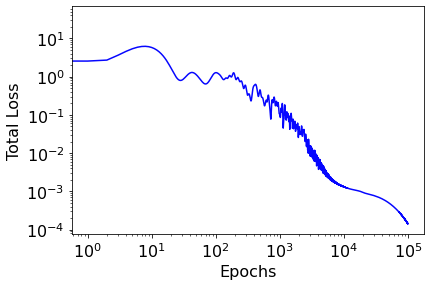

In [4]:
# Total Loss function
print('Training time (minutes):', runTime1/60)
plt.loglog(loss_hists1[0],'-b',alpha=0.975);
plt.tight_layout()
plt.ylabel('Total Loss');plt.xlabel('Epochs')

Plots of the eigenvalues (QNMs) during training.

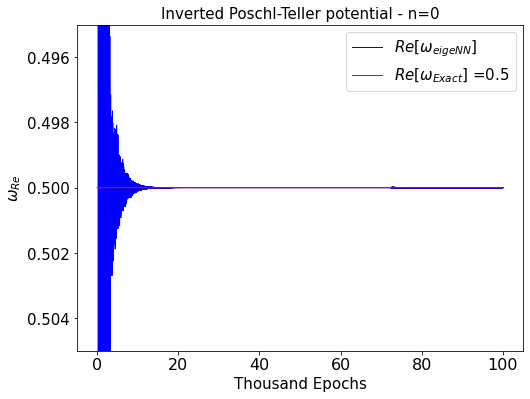

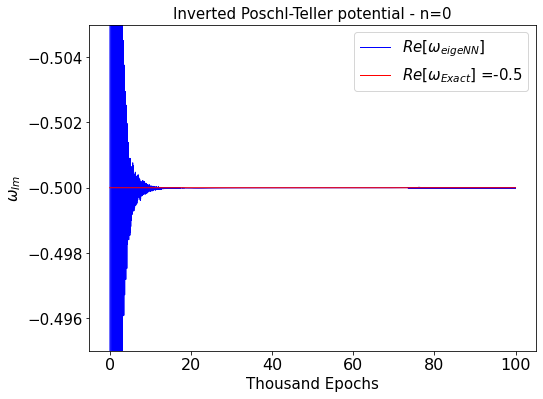

In [17]:
from google.colab import files
import matplotlib.pyplot as plt

size = 15

plt.rc('font', size=size) # controls default text sizes
plt.rc('axes', titlesize=size) # fontsize of the axes title
plt.rc('axes', labelsize=size) # fontsize of the x and y labels
plt.rc('legend', fontsize=size) # legend fontsize

# Real part
plt.figure(figsize = (8,6))
plt.ylim(float(omega_exact.real) + 0.005, float(omega_exact.real) - 0.005)
if loss_hists1[5][-1] > 0:
  plt.plot(np.arange(len(loss_hists1[5]))/1000, np.array(loss_hists1[5])*(1), '-b', linewidth=1, label ='$Re[\omega_{eigeNN}]$')
else:
  plt.plot(np.arange(len(loss_hists1[5]))/1000, np.array(loss_hists1[5])*(-1), '-b', linewidth=1, label ='$Re[\omega_{eigeNN}]$')

plt.plot(np.arange(len(loss_hists1[5]))/1000, np.ones_like(loss_hists1[5])*(omega_exact.real), '-r', linewidth=1, label = '$Re[\omega_{Exact}]$ =' + '{}'.format(round(omega_exact.real, 6)))

plt.legend()
plt.title("Inverted Poschl-Teller potential - n={}".format(N))
plt.ylabel('$\omega_{Re}$');plt.xlabel('Thousand Epochs')
plt.savefig("plot1.pdf", bbox_inches='tight')
#files.download("plot1.pdf")

#Imaginary part
plt.figure(figsize = (8,6))
plt.ylim(float(omega_exact.imag) + 0.005, float(omega_exact.imag) - 0.005)
if loss_hists1[6][-1] > 0:
  plt.plot(np.arange(len(loss_hists1[6]))/1000, np.array(loss_hists1[6])*(-1),'-b', linewidth=1, label ='$Re[\omega_{eigeNN}]$')
else:
  plt.plot(np.arange(len(loss_hists1[6]))/1000, np.array(loss_hists1[6]),'-b', linewidth=1, label ='$Re[\omega_{eigeNN}]$')

plt.plot(np.arange(len(loss_hists1[5]))/1000, np.ones_like(loss_hists1[5])*(omega_exact.imag), '-r', linewidth=1, label = '$Re[\omega_{Exact}]$ =' + '{}'.format(round(omega_exact.imag, 6)))

plt.legend()
plt.title("Inverted Poschl-Teller potential - n={}".format(N))
plt.ylabel('$\omega_{Im}$');plt.xlabel('Thousand Epochs')
plt.savefig("plot2.pdf", bbox_inches='tight')
#files.download("plot2.pdf")


Just picking out the QNM values with the least PDE loss/residual (I assume that the PDE loss is the best accuracy metric).

In [8]:
PE_loss = []
for i in range(len(loss_hists1[2])):
    val= float(loss_hists1[2][i])
    PE_loss.append(val)

#Determining the epoch with minimum PDE loss/residual residual
minloss = np.amin(np.array(loss_hists1[2])) 
print('The minimum perturbation equation residual is_ {}_ which occurs when the approx QNMs are:'.format(minloss))
epoch = (np.where(np.array(PE_loss)[:, None] == np.amin(np.array(PE_loss)[:, None]))[0])


#Picking out the eigenvalues/ QNMs corresponding to the minimum PDE loss.
if loss_hists1[5][-1] > 0:
  omega1 = loss_hists1[5][int(epoch)]
else:
  omega1 = loss_hists1[5][int(epoch)]*(-1)  

if loss_hists1[6][-1] > 0:
  omega2 = loss_hists1[6][int(epoch)]*(-1)
else:
  omega2 = loss_hists1[6][int(epoch)]  

#The percentage deviations of these QNMs. Where percentage deviation = L2 relative error * 100
PDev1 = loss_hists1[7][int(epoch)]
PDev2 = loss_hists1[8][int(epoch)]

print('omega_real | omega_imag| omega_real percentage deviation | omega_imag percentage deviation | runtime |')
print('{} | {} | {}% | {}% | {} minutes |'.format(omega1,omega2, PDev1, PDev2, round(runTime1/60)))


The minimum perturbation equation residual is_ 3.655396758712154e-09_ which occurs when the approx QNMs are:
omega_real | omega_imag| omega_real percentage deviation | omega_imag percentage deviation | runtime |
0.49999997306627914 | -0.4999996865353559 | -5.386744172941604e-06% | -6.269292881500022e-05% | 11 minutes |


# QNM wavefunctions

Plotting the QNM wavefunctions.

In [11]:
import cmath
import math
import mpmath as mp
import numpy as np

num_domain = int(1e4); 

M = 1 # mass of black hole
kappa = 1 

# radial coordinate (distance from the center of BH)
r = np.linspace(2,10,num_domain).reshape(-1,1)
r1 = np.linspace(0,10,num_domain)
r2 = torch.linspace(2, 10, num_domain).reshape(-1,1)

# relationship between x coordinate and radial coordinate
x = r + 2*M*np.log(-2*M + r)
x1 = r1 + 2*M*np.log(-2*M + r1)
x2 = r2 + 2*M*torch.log(-2*M + r2)

y2 = torch.tanh(x2)
Phi1, Phi2 = Parametric_Solution(y2,loss_hists1[9][0][0],0) # Phi(y)

phi1 = -1*Phi1.data.numpy()/np.max(np.abs(Phi1.data.numpy()))
phi2 = -1*Phi2.data.numpy()/np.max(np.abs(Phi2.data.numpy()))

#V0 = (kappa**2)*(L)*(L + 1)
V0 = 0.5
#Omega = (kappa**2)*(-(N + 1/2)*1j + ((V0/(kappa**2)) - (1/4))**(1/2))
Omega = (1/2) - (N + (1/2))*1j

def psi(r):# exact
    psi_real = []
    psi_imag = []

    for i in r: # x = tortoise coordinate
      x = i + 2*M*mp.log(-2*M + i)
      Xi = 1/(1 + mp.exp(-2*kappa*x))      
      Beta = -(1/2) + ((1/4) - (V0/(kappa**2)))**(1/2)
      a = 1 + Beta - ((Omega*1j)/kappa)
      b = -Beta - ((Omega*1j)/kappa)
      c = 1 - ((Omega*1j)/kappa)
      z = Xi
      
      #Ferrari & Mashhoon, Appendix A 
      real = float(mp.re(((Xi*(1 - Xi))**(-(Omega*1j)/(2*kappa)))*mp.hyp2f1(a, b, c, z)))
      imag = float(mp.im(((Xi*(1 - Xi))**(-(Omega*1j)/(2*kappa)))*mp.hyp2f1(a, b, c, z)))
      psi_real.append(real)
      psi_imag.append(imag)
    return np.array(psi_real), np.array(psi_imag)

omega = omega1 + omega2*1j

def Psi(r): #PINN approximation
  x = r + 2*M*np.log(-2*M + r)
  y = np.tanh(x)
  real = np.real(((1 - y)**((-1j*omega)/2))*((1 + y)**((-1j*omega)/2))*(phi1 + phi2*1j))
  imag = np.imag(((1 - y)**((-1j*omega)/2))*((1 + y)**((-1j*omega)/2))*(phi1 + phi2*1j))
  return real, imag  

psi1, psi2 = psi(r1)
Psi1, Psi2 = Psi(r2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log


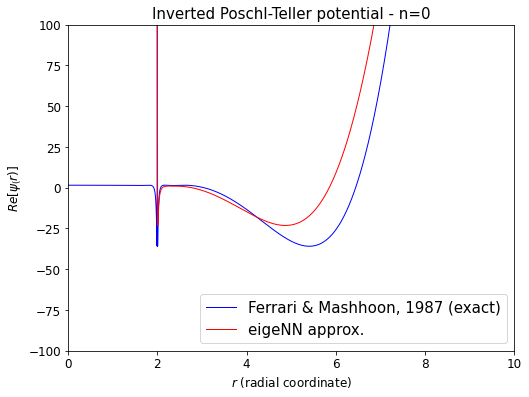

In [15]:
# plotting the real part of Psi

# Figure boundaries
plt.figure(figsize = (8,6))
plt.ylim([-100, 100])
plt.xlim([0, 10])

# Actual plot
plt.plot(r1, psi1,'-b', linewidth=1, label="Ferrari & Mashhoon, 1987 (exact)")
plt.plot(r2, Psi1,'-r', linewidth=1, label="eigeNN approx.")
plt.legend(loc ="lower right")

# Font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', size=12) 
plt.rc('axes', labelsize=12)

# Plot axes Labels
plt.title("Inverted Poschl-Teller potential - n={}".format(N)) #+ "\n" + "percentage deviation: {}".format()
plt.ylabel('$Re[\psi_(r)]$');
plt.xlabel('$r$ (radial coordinate)')
plt.savefig("wavefunction1.pdf", bbox_inches='tight') #saving as pdf
#files.download("wavefunction1.pdf")


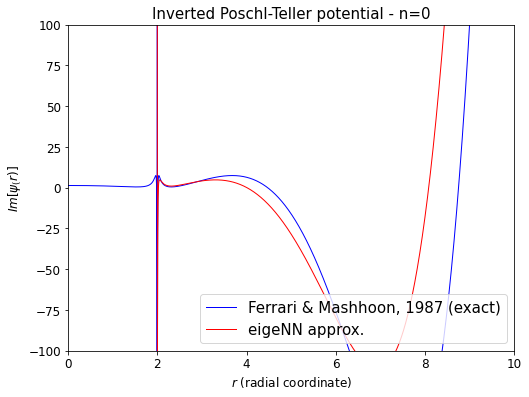

In [16]:
# plotting the real part of Psi

# Figure boundaries
plt.figure(figsize = (8,6))
plt.ylim([-100, 100])
plt.xlim([0, 10])

# Actual plot
plt.plot(r1, psi2,'-b', linewidth=1, label="Ferrari & Mashhoon, 1987 (exact)")
plt.plot(r2, Psi2,'-r', linewidth=1, label="eigeNN approx.")
plt.legend(loc ="lower right")

# Font sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.rc('font', size=12) 
plt.rc('axes', labelsize=12)

# Plot axes Labels
plt.title("Inverted Poschl-Teller potential - n={}".format(N)) #+ "\n" + "percentage deviation: {}".format()
plt.ylabel('$Im[\psi_(r)]$');
plt.xlabel('$r$ (radial coordinate)')
plt.savefig("wavefunction2.pdf", bbox_inches='tight') #saving as pdf
#files.download("wavefunction2.pdf")
